In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import scanpy as sc
import seaborn as sns
import sklearn
import umap.umap_ as umap

from pathlib import Path

np.random.seed(1)
random.seed(1)

/Users/dustinm/projects/GenePT-test/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
import util
import importlib
importlib.reload(util)

N_genes, N_dims, gpt_embeddings = util.retrieve_gpt_gene_embeddings()
print(f"(N_genes, N_dims) = {N_genes}, {N_dims}") 

(N_genes, N_dims) = 93800, 1536


In [35]:
sampled_aorta_data = sc.read_h5ad(util.data_dir / "sample_aorta_data_updated.h5ad")
N_cells = sampled_aorta_data.n_obs
N_genes = sampled_aorta_data.n_vars
print(f"(N_genes, N_cells) = {N_genes}, {N_cells}")

(N_genes, N_cells) = 23331, 9625


/Users/dustinm/projects/GenePT-test/venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [36]:
sc.pp.normalize_total(sampled_aorta_data)
sc.pp.log1p(sampled_aorta_data)
print(sampled_aorta_data)

if isinstance(sampled_aorta_data.X, np.ndarray):
    X_dense = sampled_aorta_data.X
else:
    X_dense = sampled_aorta_data.X.toarray()

# Convert data to a probability distribution
X_prob = X_dense / X_dense.sum(axis=1, keepdims=True)

AnnData object with n_obs × n_vars = 9625 × 23331
    obs: 'patient', 'status', 'n_counts', 'n_counts_normalized', 'n_counts_normalized_log', 'cell_id', 'patient_rename', 'Unnamed: 0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'integrated_snn_res.0.6', 'seurat_clusters', 'celltype', 'celltype2', 'cellcycle', 'split_value', 'phenotype'
    var: 'ensembl_id'
    uns: 'log1p', 'neighbors', 'patient_colors', 'pca', 'status_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [37]:
# Reindex gpt_embeddings based on aorta data

Y = []
for gene in sampled_aorta_data.var_names:
    embedding = gpt_embeddings.get(gene, np.zeros(N_dims))
    Y.append(embedding)
Y = np.array(Y)
Y.shape

(23331, 1536)

In [38]:
# weighted cell embedding can be computed efficiently via matrix multiplication
# (cell x embedding) = (cell x genes) . (genes x embedding) 
#                    = [ normalized X ] . [ gpt_embedding ]

X_embeddings = X_prob @ Y
X_embeddings.shape

(9625, 1536)

/Users/dustinm/projects/GenePT-test/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


([], [])

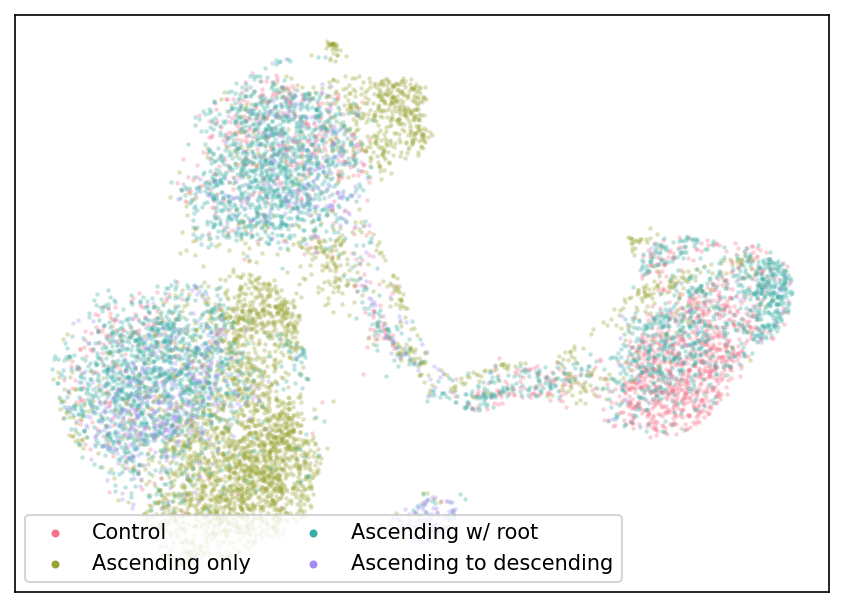

In [47]:
pca = sklearn.decomposition.PCA(n_components=50)
pca_result = pca.fit_transform(X_embeddings)

embedding_sanity_check = umap.UMAP(min_dist=0.5, spread=1).fit_transform(pca_result)

plt.rcParams['axes.facecolor'] = 'white'
plt.figure(figsize=(7,5), dpi=150)

np.random.seed(1)
random.seed(1)

all_labels = np.unique(sampled_aorta_data.obs.phenotype)
random.shuffle(all_labels)
colors = sns.color_palette('husl', len(all_labels))
for i, label_name in enumerate(all_labels):
    plt.scatter(embedding_sanity_check[sampled_aorta_data.obs.phenotype==label_name, 0], 
                        embedding_sanity_check[sampled_aorta_data.obs.phenotype==label_name, 1], s= 2,
                        label=label_name,color=colors[i],alpha=0.2)
leg = plt.legend(prop={'size': 10},loc='lower left',ncol=2)
plt.rcParams["legend.markerscale"] = 2.0
for lh in leg.legend_handles: 
    lh.set_alpha(1)
plt.xticks([])
plt.yticks([])

([], [])

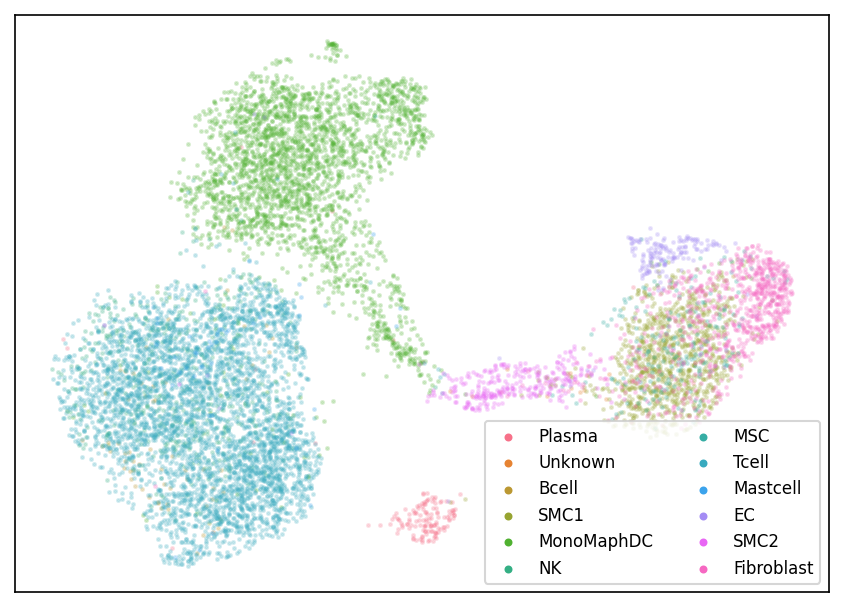

In [49]:
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(7,5), dpi=150) 

np.random.seed(1)
random.seed(1)

all_labels = np.unique(sampled_aorta_data.obs.celltype)
random.shuffle(all_labels)
colors = sns.color_palette('husl', len(all_labels))
for i, label_name in enumerate(all_labels):
    plt.scatter(embedding_sanity_check[sampled_aorta_data.obs.celltype==label_name, 0], 
                        embedding_sanity_check[sampled_aorta_data.obs.celltype==label_name, 1], s= 2,
                        label=label_name,color=colors[i],alpha=0.2)
leg = plt.legend(prop={'size': 8},loc='lower right',ncol=2)
plt.rcParams["legend.markerscale"] = 2.0
for lh in leg.legend_handles: 
    lh.set_alpha(1)
plt.xticks([])
plt.yticks([])

([], [])

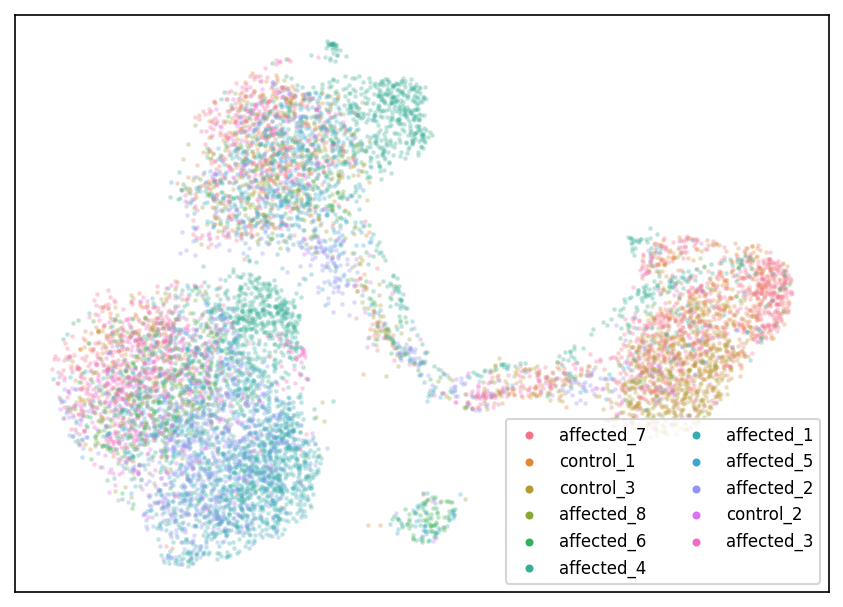

In [50]:
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(7,5), dpi=150) 

np.random.seed(1)
random.seed(1)

all_labels = np.unique(sampled_aorta_data.obs.patient)
random.shuffle(all_labels)
colors = sns.color_palette('husl', len(all_labels))
for i, label_name in enumerate(all_labels):
    plt.scatter(embedding_sanity_check[sampled_aorta_data.obs.patient==label_name, 0], 
                        embedding_sanity_check[sampled_aorta_data.obs.patient==label_name, 1], s= 2,
                        label=label_name,color=colors[i],alpha=0.2)
leg = plt.legend(prop={'size': 8},loc='lower right',ncol=2)
plt.rcParams["legend.markerscale"] = 2.0
for lh in leg.legend_handles: 
    lh.set_alpha(1)
plt.xticks([])
plt.yticks([])